# IR Project: Retrieval of Computer Science academic documents applying Neural approaches

Group Components:

*   Simone Benitozzi, 889407

*   Mattia Beolchi, 844911

*   Vincenzo Vommaro Marincola, 878533



# Import Dependencies

**THE FIRST CELL MUST BE EXECUTED TWICE**

- The first time the compatible version of numpy will be installed, then restarting the runtime

- The second time it will just print out the current version of the library, proceeding with the execution of the following cells.

In [ ]:
import numpy as np
import os

if not (np.version.version == '1.22.4'):
  !pip install --upgrade numpy==1.22.4
  os.kill(os.getpid(), 9)
else:
  print("numpy version:", np.version.version)

numpy version: 1.22.4


Mounting Google Drive to use disk storage:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Drive directory containing the dataset:
ds_dir = '/content/drive/My Drive/IR_project/computer_science/'

Mounted at /content/drive


Library used for jsonl dynamic reading: https://github.com/AmenRa/indxr

Library used for neural re-ranking: https://github.com/Georgetown-IR-Lab/OpenNIR

Library used for Wordclouds: https://pypi.org/project/wordcloud/

In [ ]:
%%capture
!pip install indxr
!pip install jsonlines
!pip install KrovetzStemmer
!pip install --upgrade python-terrier
!pip install wordcloud
!pip install -U kaleido

!pip install --upgrade git+https://github.com/Georgetown-IR-Lab/OpenNIR
!pip install --upgrade git+https://github.com/terrierteam/pyterrier_t5

In [ ]:
%%capture
import os
import pickle
import tqdm
from tqdm import tqdm

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

from indxr import Indxr
import json
import jsonlines
import string
import regex as re
from bs4 import BeautifulSoup

import nltk
from krovetzstemmer import Stemmer
from nltk.corpus import stopwords

import gc
gc.enable()
import pandas as pd
pd.set_option('display.max_colwidth', None)

import pyterrier as pt
if not pt.started():
  #add logging="INFO" if you want to see normal Terrier output
  #request 8GM ram for indexing
  pt.init(mem = 8000)
from pyterrier.measures import *
import onir_pt # OpenNIR

from gensim import downloader
from gensim.models import Word2Vec 

nltk.download('punkt')
wiki_model = downloader.load("glove-wiki-gigaword-100")

In [ ]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

def save_fig_table(df, name):
    name = name[:-4]+".png"

    df = df.round(5)

    fig,ax = render_mpl_table(df, header_columns=0, col_width=5.0)
    fig.savefig(ds_dir+"tables/"+name)

In [ ]:
def save_latex_table(df, name):

    if not name.endswith(".tex"):
        name = name+".tex"

    with open(ds_dir+"tables/"+name, 'w') as file:
        file.write(df.to_latex())
    file.close()

    save_fig_table(df, name)

# 1. Data Preprocessing

In [ ]:
### --- Defining Functions to be used in preprocessing(): --- ###

def remove_extra_whitespaces(x):
    return " ".join(x.split())

def acronyms_callback(x):
    # Removing dots in acronyms 
    return x.replace(".", "")

def strip_acronyms(x):
    x = re.sub(r"(?:[a-z]\.)+", lambda m: acronyms_callback(m.group()), x)
    x = re.sub(r"(?<=\b\w)\s*(?=\w\b)", "", x)
    return x

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def normalize_and(x):
    return x.replace("&", " and ")

def remove_links(text):
  # Removing all the occurrences of links that starts with https
  remove_https = re.sub(r'http\S+', ' ', text)
  # Remove all the occurrences of text that ends with .com
  remove_com = re.sub(r"www\.[A-Za-z]*\.com", " ", remove_https)
  return remove_com

def strip_html_tags(text):
  # Initiating BeautifulSoup object soup.
  soup = BeautifulSoup(text, "html.parser")
  # Get all the text other than html tags.
  stripped_text = soup.get_text(separator=" ")
  return stripped_text

def remove_stop_words(x, stopword_list):
    return " ".join(t for t in x.split() if t not in stopword_list)

def stemming(x):
    stemmer = Stemmer()
    return " ".join(stemmer(y) for y in x.split())

In [ ]:
def preprocessing(x):
    # load text as string (lower text)
    x = str(x)
    x = x.lower()

    # basic preprocessing
    x = remove_punctuation(x)
    x = strip_acronyms(x)
    x = normalize_and(x)

    # links and html (noise reduction)
    x = remove_links(x)
    x = strip_html_tags(x)

    # Load stopwords list:
    try:
        stopword_list = stopwords.words("english")
    except:
        nltk.download("stopwords")
        stopword_list = stopwords.words("english")
    abbreviation_suffixes = ["d", "ll", "m", "re", "s", "t", "ve"] # additional custom stopwords to concatenate
    stopword_list = stopword_list + abbreviation_suffixes
    stopword_list = set(stopword_list)

    # normalization
    x = remove_stop_words(x, stopword_list)
    x = stemming(x)

    # removing multiple whitespaces that may have been introduced by the previous preprocessing operations
    x = remove_extra_whitespaces(x)

    return x


In [ ]:
def preprocess_doc(doc):

    # create json object conataining document id and document content (consisting of title+abstract text):
    doc = {
        "id": doc["id"],
        "contents": preprocessing(doc["title"] + "\n" + doc["text"]),
    }

    return doc
    
def preprocess_collection(dir_path):

    collection_path = dir_path+"collection.jsonl" # the original jsonl file
    target_path = dir_path+"collection_preprocessed.jsonl" # the new jsonl file, where preprocessed docs will be stored

    if os.path.exists(target_path):
        print("Preprocessed Collection already exists!")
        return

    collection_indexer = Indxr(ds_dir+"collection.jsonl")

    with jsonlines.open(target_path, mode='w') as f_out:
        
        for i in tqdm(len(collection_indexer)):
            doc = collection_indexer[i]      # for each document in the collection
            doc = preprocess_doc(doc)           # preprocess its content
            f_out.write(doc)                    # and write it in the target file

        f_out.close()

In [ ]:
preprocess_collection(ds_dir)

print("Loading new Collection indexer . . .")
preprocessed_indexer = Indxr(ds_dir+"collection_preprocessed.jsonl")

Preprocessed Collection already exists!
Loading new Collection indexer . . .


# 2. Data Indexing

## Full Collection

The full Collection indexing will be used to retrieve, more efficiently, useful statistics about the original text corpus

This indexing will *not* be used for search pipelines and retrieval models

In [ ]:
def iter_file(filename):
    with open(filename, 'rt') as file:
        for l in tqdm(file):
            # yields a dictionary for each json line
            doc = json.loads(l)
            yield {'docno' : doc["id"], 'text' : doc["text"]}
        file.close()

gc.collect()
index_dir = ds_dir + "index_full/"

if not os.path.exists(index_dir+"data.properties"):
    index_full_ref = pt.IterDictIndexer(index_dir).index(iter_file(ds_dir+"collection.jsonl"), 
                                                    meta = ('docno', 'text'), fields = ('text',))
else:
    print("Index already created!")
    index_full_ref = pt.IndexRef.of(index_dir+"data.properties")

gc.collect()

Index already created!


0

## Preprocessed Collection

The Preprocessed Collection indexing will be used for both the retrieval of useful statistics and for search pipelines and retrieval models as well

In [ ]:
def iter_file(filename):
    with open(filename, 'rt') as file:
        for l in tqdm(file):
            # yields a dictionary for each json line
            doc = json.loads(l)
            yield {'docno' : doc["id"], 'contents' : doc["contents"]}
        file.close()

gc.collect()
index_dir = ds_dir + "index/"

if not os.path.exists(index_dir+"data.properties"):
    index_ref = pt.IterDictIndexer(index_dir).index(iter_file(ds_dir+"collection_preprocessed.jsonl"), 
                                                    meta = ('docno', 'contents'), fields = ('contents',))
else:
    print("Index already created!")
    index_ref = pt.IndexRef.of(index_dir+"data.properties")

index = pt.IndexFactory.of(index_ref)
gc.collect()

Index already created!


0

# 3. Dataset Analysis

In the following we analyze and present the collection statistics, for both the original and the preprocessed one.  \\
Then we analyze the test queries, present graphs and word-clouds.

## Collection Analysis

In [ ]:
index = pt.IndexFactory.of(index_full_ref)
print(index.getCollectionStatistics())

stats = index.getCollectionStatistics().toString().split()

docs_idx = stats.index("documents:")+1
n_docs = int(stats[docs_idx])

tokens_idx = stats.index("tokens:")+1
n_tokens = int(stats[tokens_idx])

print("Number of avg tokens per Document: ", round(n_tokens/n_docs, 2))

Number of documents: 4809684
Number of terms: 1020823
Number of postings: 255410235
Number of fields: 1
Number of tokens: 399565930
Field names: [text]
Positions:   false

Number of avg tokens per Document:  83.08


## Preprocessed Collection Analysis

In [ ]:
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics().toString())

stats = index.getCollectionStatistics().toString().split()

docs_idx = stats.index("documents:")+1
n_docs = int(stats[docs_idx])

tokens_idx = stats.index("tokens:")+1
n_tokens = int(stats[tokens_idx])

print("Number of avg tokens per Document: ", round(n_tokens/n_docs, 2))

Number of documents: 4809684
Number of terms: 2225016
Number of postings: 253719768
Number of fields: 1
Number of tokens: 415050364
Field names: [contents]
Positions:   false

Number of avg tokens per Document:  86.29


## Queries Analysis

In this section there will be presented an analysis of the test queries (the ones on which the final results will be evaluated)

Due to the smaller size of the document, a more detailed analysis was possible, including word clouds and term frequency for each token present in the query corpus

In [ ]:
if os.path.exists(ds_dir+"cache/query_test_df.csv") and os.path.exists(ds_dir+"cache/qrels_test_df.csv"):
    print("Loading query dataframes from cache . . .")
    
    query_test_df = pd.read_csv(ds_dir+"cache/query_test_df.csv", dtype=str)
    qrels_test_df = pd.read_csv(ds_dir+"cache/qrels_test_df.csv", dtype=str)
    qrels_test_df["label"] = qrels_test_df["label"].astype(int)

else:
    query_test_indexer = Indxr(ds_dir+"test/queries.jsonl")

    print("Creating dataframes . . .")
    print("Test queries: ", len(query_test_indexer))

    query_test_df = pd.DataFrame(columns = ["qid", "query"])
    qrels_test_df = pd.DataFrame(columns = ["qid", "docno", "label"])

    for query in query_test_indexer:
    
        # append query id and query corpus
        query_test_df.loc[len(query_test_df)] = [str(query["id"]), query["text"]]

        # append all relevant documents
        qrels = query["rel_doc_ids"]
        for id in qrels:
            qrels_test_df.loc[len(qrels_test_df)] = [str(query["id"]), str(id), 1]

    # preprocessing query corpus
    query_test_df["query"] = query_test_df["query"].apply(preprocessing)

    # caching for future executions
    query_test_df.to_csv(ds_dir+"cache/query_test_df.csv", index=False)
    qrels_test_df.to_csv(ds_dir+"cache/qrels_test_df.csv", index=False)
    

Loading query dataframes from cache . . .


Analysis of basic stats for the queries, including the total number of queries, words per query and an estimate of relevant documents for each query

In [ ]:
print(f"There are {query_test_df.shape[0]} queries in the test set. \n")
print(f"There are {qrels_test_df.shape[0]} relevant documents for the test queries (out of the total {n_docs} documents in the collection)")
print(f"For an average of {round(qrels_test_df.shape[0]/query_test_df.shape[0], 2)} relevant documents per query\n")

query_corpus = " ".join(query for query in query_test_df["query"])
print(f"There are {len(query_corpus.split())} words (out of which {len(np.unique(query_corpus.split()))} are unique) in the combination of all queries")
print(f"The average number of words for each query is {round(len(query_corpus.split())/query_test_df.shape[0], 2)}")

There are 6497 queries in the test set. 

There are 108636 relevant documents for the test queries (out of the total 4809684 documents in the collection)
For an average of 16.72 relevant documents per query

There are 58881 words (out of which 6291 are unique) in the combination of all queries
The average number of words for each query is 9.06


In the following cell a WordCloud for queries is displayed: this offers a visual representation of which words are more frequent in the query corpus

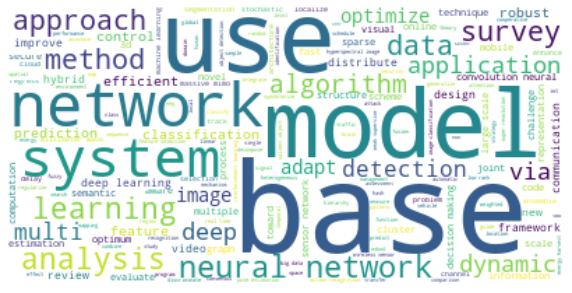

In [ ]:
%matplotlib inline

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white").generate(query_corpus)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

fig = plt.gcf()
fig.set_size_inches(10, 7)
fig.savefig(ds_dir+"figs/query_wordcloud.png", dpi=100)

plt.show()

Here we create a dictionary counting the frequency for each word appearing in the queries

In [ ]:
def count(word):
    # ignore '.' at the end
    if word[-1] == '.':
        word = word[0:len(word) - 1]
 
    if word in freq_dict:
        freq_dict[word] += 1
 
    else:
        freq_dict.update({word: 1})
 
freq_dict = {}
 
# split all the word of the string.
lst = query_corpus.split()
 
# take each word from lst and pass it to the method count.
for word in lst:
    count(word)
print("Total unique Words : {}".format(len(freq_dict.keys())))

# filter only by words with at least N occurrences
N = 150
freq_dict = dict(filter(lambda elem: elem[1] > N, freq_dict.items()))
print("Words left (with at least {} occurrences) : {}".format(N, len(freq_dict.keys())))

# sorting dictionary by occurrences
freq_dict = dict(sorted(freq_dict.items(), key=lambda x:x[1], reverse=True))

Total unique Words : 6291
Words left (with at least 150 occurrences) : 41


Displaying a bar plot for the top words frequency, that offers visual insights, more descriptive than the word cloud

For visualization purpose, only the words with at least 150 occurrences have been displayed (in order to have the top 41 frequent words, instead of all 6291)

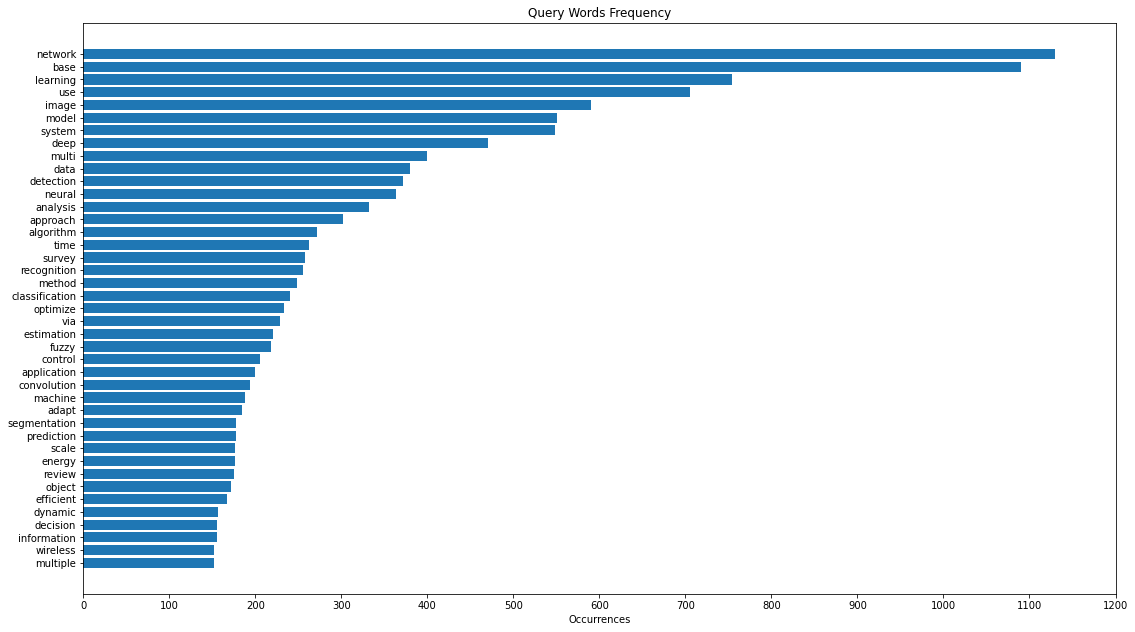

In [ ]:
%matplotlib inline

# plotting the results
fig, ax = plt.subplots()

ax.barh(["".join(w) for w in freq_dict], freq_dict.values(), align='center')
ax.set_xticks(np.arange(0, max(freq_dict.values())+100, 100))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Occurrences')
ax.set_title('Query Words Frequency')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig(ds_dir+"figs/query_freqbar.png", dpi=100)

plt.show()


# 4. Base Models Implementation

Implemtenting 4 different base models:

- **Tf** : Term Frequency
- **Tf-Idf** : Term Frequency - Inverse Document Frequency
- **BM25**: bag-of-words retrieval function that ranks a set of documents based on the query terms
appearing in each document, regardless of their proximity within the document.
- **LM Dirichlet Similarity**: Dirichlet Prior Smoothing

In [ ]:
tfidf = pt.BatchRetrieve(index, wmodel = "TF_IDF")
tf = pt.BatchRetrieve(index, wmodel = "Tf")
bm25 = pt.BatchRetrieve(index, wmodel = "BM25")
dir_lm = pt.BatchRetrieve(index, wmodel = "DirichletLM")

## Effectiveness Test and Comparison

Metrics chosen for Comparison:

- **Precision@10:** Precision up to rank 10 result
- **Recall@10:** Recall up to rank 10 result
- **NDCG@10:**  Normalized Discounted Cumulative Gain up to rank 10 result
- **(Mean) Average Precision@100:** up to rank 100 result
- **(Mean) Reciprocal Rank@100:** up to rank 100 result

Link documento: https://ir-measur.es/_/downloads/en/latest/pdf/ \\
Lista metriche disponibili: https://pyterrier.readthedocs.io/en/latest/experiments.html#available-evaluation-measures

In [ ]:
def experiment_models(models, names=None):
    return pt.Experiment(
        models,
        query_test_df,
        qrels_test_df,
        names=names,
        eval_metrics=[P@10, R@10, nDCG@10, AP@100, RR@100]
    )

In [ ]:
def compare_results(dataframes, df_name):
    df = pd.concat(dataframes)
    df.sort_values("P@10", ascending=False, inplace=True)

    save_latex_table(df, df_name)
    display(df)

    return df

Loading Experiments on test queries . . .


,name,P@10,R@10,nDCG@10,AP@100,RR@100
0,TF_IDF,0.166384,0.106992,0.190944,0.099761,0.441662
2,BM25,0.165584,0.106653,0.189841,0.099566,0.438675
3,DirichletLM,0.141188,0.090756,0.160028,0.081381,0.377222
1,Tf,0.006326,0.003843,0.006085,0.002842,0.023874


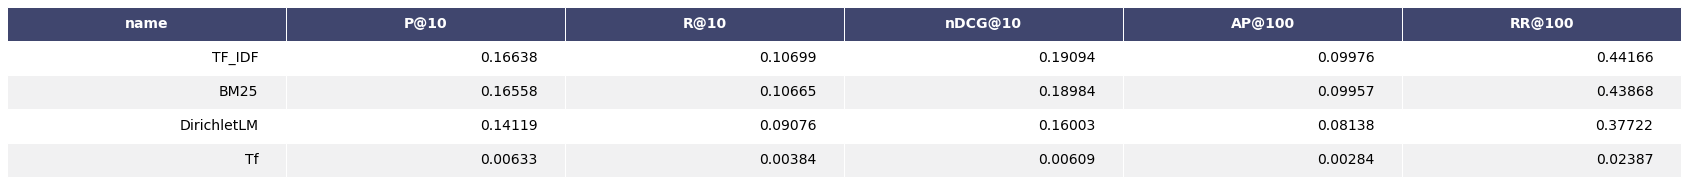

In [ ]:
if os.path.exists(ds_dir+"cache/base_models_results.csv"):
    print("Loading Experiments on test queries . . .")
    base_results = pd.read_csv(ds_dir+"cache/base_models_results.csv")

else:
    print("Running Experiments on test queries . . .")

    base_results = experiment_models(
        [tfidf, tf, bm25, dir_lm],
        names=["TF_IDF", "Tf", "BM25", "DirichletLM"])

    base_results.to_csv(ds_dir+"cache/base_models_results.csv", index=False)

base_results = compare_results([base_results], "base_results.tex")
top2_df = base_results.head(2)

## Query Expansion and Rewriting

In this section we apply some query Rewriting techniques to see if the performances improve

**Kullback-Leibler Divergence**

In [ ]:
df_path = ds_dir+"cache/tfidf_kl.csv"

if os.path.exists(df_path):
    print("Loading TFIDF-KL results . . .")
    tfidf_kl_df = pd.read_csv(df_path)

else:
    kl_pipeline = tfidf >> pt.rewrite.KLQueryExpansion(index_ref) >> tfidf
    tfidf_kl_df = experiment_models([kl_pipeline], ["TF-IDF >> KL"])

    tfidf_kl_df.to_csv(df_path, index=False)

Loading TFIDF-KL results . . .


In [ ]:
df_path = ds_dir+"cache/bm25_kl.csv"

if os.path.exists(df_path):
    print("Loading BM25-KL results . . .")
    bm25_kl_df = pd.read_csv(df_path)

else:
    kl_pipeline = bm25 >> pt.rewrite.KLQueryExpansion(index_ref) >> bm25
    bm25_kl_df = experiment_models([kl_pipeline], ["BM25 >> KL"])

    bm25_kl_df.to_csv(df_path, index=False)


Loading BM25-KL results . . .


**Query Tokeniser**

In [ ]:
df_path = ds_dir+"cache/tfidf_query_tokeniser.csv"

if os.path.exists(df_path):
    print("Loading TFIDF-TOKENISER results . . .")
    tfidf_tokeniser_df = pd.read_csv(df_path)

else:
    qt_pipe = pt.rewrite.tokenise() >> tfidf
    tfidf_tokeniser_df = experiment_models([qt_pipe], ["TF-IDF >> TOKENISER"])

    tfidf_tokeniser_df.to_csv(df_path, index=False)

Loading TFIDF-TOKENISER results . . .


In [ ]:
df_path = ds_dir+"cache/bm25_query_tokeniser.csv"

if os.path.exists(df_path):
    print("Loading BM25-TOKENISER results . . .")
    bm25_tokeniser_df = pd.read_csv(df_path)

else:
    qt_pipe = pt.rewrite.tokenise() >> bm25
    bm25_tokeniser_df = experiment_models([qt_pipe], ["BM25 >> TOKENISER"])

    bm25_tokeniser_df.to_csv(df_path, index=False)

Loading BM25-TOKENISER results . . .


**Display Performances**

The *KL-Divergence* gives better than the 2 base results, while the *Query Tokeniser* only has very slight improvements on the Average Precision and Reciprocal Rank

,name,P@10,R@10,nDCG@10,AP@100,RR@100
0,TF-IDF >> KL,0.175050,0.112700,0.197272,0.109632,0.436601
0,BM25 >> KL,0.174065,0.112141,0.196082,0.109301,0.434015
0,TF_IDF,0.166384,0.106992,0.190944,0.099761,0.441662
2,BM25,0.165584,0.106653,0.189841,0.099566,0.438675


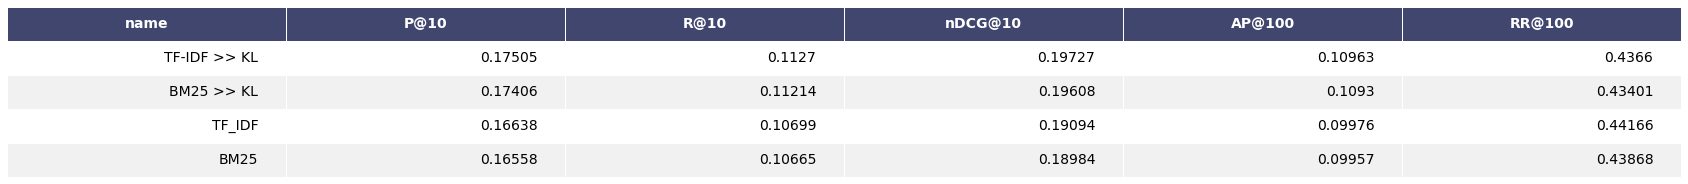

In [ ]:
KL_df = compare_results([top2_df,  tfidf_kl_df, bm25_kl_df], "KL_comparison.tex")

,name,P@10,R@10,nDCG@10,AP@100,RR@100
0,TF_IDF,0.166384,0.106992,0.190944,0.099761,0.441662
0,TF-IDF >> TOKENISER,0.166384,0.106992,0.190944,0.099762,0.441666
2,BM25,0.165584,0.106653,0.189841,0.099566,0.438675
0,BM25 >> TOKENISER,0.165584,0.106653,0.189841,0.099568,0.438679


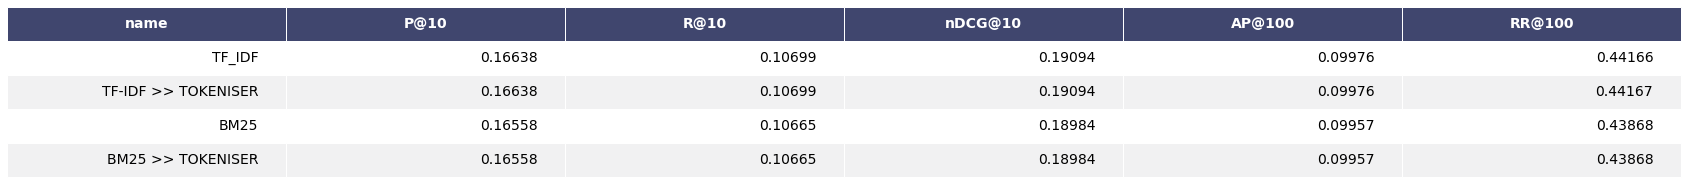

In [ ]:
tokeniser_df = compare_results([top2_df, tfidf_tokeniser_df, bm25_tokeniser_df], "tokeniser_comparison.tex")

# 5. Neural Implementation

In this section various neural approaches will be tried, from KRNM to Bert. Then we will try to perform a weighting of the best neural model obtained

## Neural Re-Ranker: KNRM

The first re-ranker used was KNRM : the first attempt was to use it in combination with a word2vec vocabulary, but both the *wordvec_unk* and *wordvec_hash* were too heavy for the RAM limits offered
by Colab, so we had to use it in combination with a *Bert* vocabulary

In [ ]:

df_path = ds_dir+"cache/tfidf_knrm.csv"

if os.path.exists(df_path):
    print("Loading TFIDF-KNRM results . . .")
    tfidf_knrm_df = pd.read_csv(df_path)

else:
    knrm = onir_pt.reranker('knrm', 'bert', text_field = 'contents') # usato bert perchè wordvec troppo pesante

    tfidf_100 = pt.BatchRetrieve(index, wmodel = "TF_IDF") % 100
    tfidf_knrm = tfidf_100 >> pt.text.get_text(index_ref, "contents") >> knrm

    tfidf_knrm_df = experiment_models([tfidf_knrm], ["TF_IDF >> KNRM"])
    tfidf_knrm_df.to_csv(df_path, index = False)

Loading TFIDF-KNRM results . . .


In [ ]:
df_path = ds_dir+"cache/bm25_knrm.csv"

if os.path.exists(df_path):
    print("Loading BM25-KNRM results . . .")
    bm25_knrm_df = pd.read_csv(df_path)
    
else:   
    knrm = onir_pt.reranker('knrm', 'bert', text_field = 'contents') # usato bert perchè wordvec troppo pesante
    
    bm25_100 = pt.BatchRetrieve(index, wmodel = "BM25") % 100
    bm25_knrm = bm25_100 >> pt.text.get_text(index_ref, "contents") >> knrm

    bm25_knrm_df = experiment_models([bm25_knrm], ["BM25 >> KNRM"])
    bm25_knrm_df.to_csv(df_path, index = False)

Loading BM25-KNRM results . . .


,name,P@10,R@10,nDCG@10,AP@100,RR@100
0,TF_IDF,0.166384,0.106992,0.190944,0.099761,0.441662
2,BM25,0.165584,0.106653,0.189841,0.099566,0.438675
0,BM25 >> KNRM,0.032276,0.019442,0.031387,0.033564,0.107038
0,TF_IDF >> KNRM,0.031953,0.019286,0.031709,0.033814,0.109683


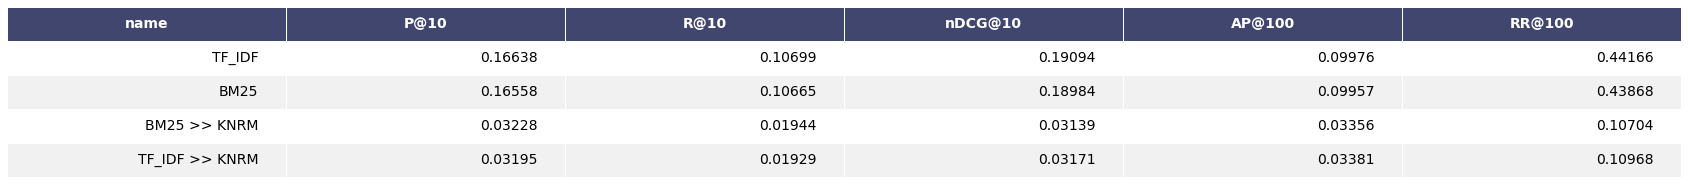

In [ ]:
knrm_df = compare_results([top2_df, tfidf_knrm_df, bm25_knrm_df], "knrm_comparison.tex")

## Neural Re-Ranker: Vanilla BERT

In [ ]:
df_path = ds_dir+"cache/tfidf_vbert.csv"

if os.path.exists(df_path):
    print("Loading Vanilla-BERT results . . .")
    tfidf_vbert_df = pd.read_csv(df_path)

else:
    vbert = onir_pt.reranker('vanilla_transformer', 'bert', text_field='contents', vocab_config={'train':True})

    tfidf_100 = pt.BatchRetrieve(index, wmodel = "TF_IDF") % 100
    tfidf_vbert = tfidf_100 >> pt.text.get_text(index_ref, "contents") >> vbert

    tfidf_vbert_df = experiment_models([tfidf_vbert], ["TF_IDF >> V-BERT"])
    tfidf_vbert_df.to_csv(df_path, index=False)

Loading Vanilla-BERT results . . .


In [ ]:
df_path = ds_dir+"cache/bm25_vbert.csv"

if os.path.exists(df_path):
    print("Loading Vanilla-BERT results . . .")
    bm25_vbert_df = pd.read_csv(df_path)

else:
    vbert = onir_pt.reranker('vanilla_transformer', 'bert', text_field='contents', vocab_config={'train':True})

    bm25_100 = pt.BatchRetrieve(index, wmodel = "BM25") % 100
    bm25_vbert = bm25_100 >> pt.text.get_text(index_ref, "contents") >> vbert

    bm25_vbert_df = experiment_models([bm25_vbert], ["BM25 >> V-BERT"])
    bm25_vbert_df.to_csv(df_path, index=False)

Loading Vanilla-BERT results . . .


,name,P@10,R@10,nDCG@10,AP@100,RR@100
0,TF_IDF,0.166384,0.106992,0.190944,0.099761,0.441662
2,BM25,0.165584,0.106653,0.189841,0.099566,0.438675
0,BM25 >> V-BERT,0.064445,0.040387,0.062490,0.046706,0.168578
0,TF_IDF >> V-BERT,0.064260,0.040323,0.062253,0.046603,0.168213


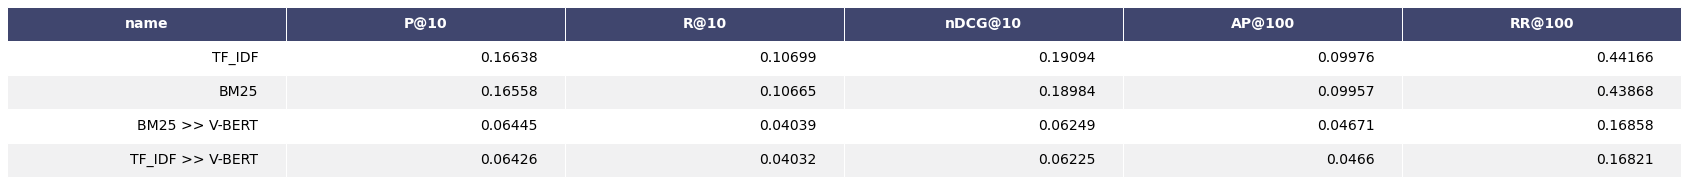

In [ ]:
knrm_df = compare_results([top2_df, tfidf_vbert_df, bm25_vbert_df], "vbert_comparison.tex")

## Weighting Neural Re-Rankers

The previous cells showed how the vanilla neural rerankers give worst performance than the base models. Next there's a comparison between the 4 results:

,name,P@10,R@10,nDCG@10,AP@100,RR@100
0,BM25 >> V-BERT,0.064445,0.040387,0.062490,0.046706,0.168578
0,TF_IDF >> V-BERT,0.064260,0.040323,0.062253,0.046603,0.168213
0,BM25 >> KNRM,0.032276,0.019442,0.031387,0.033564,0.107038
0,TF_IDF >> KNRM,0.031953,0.019286,0.031709,0.033814,0.109683


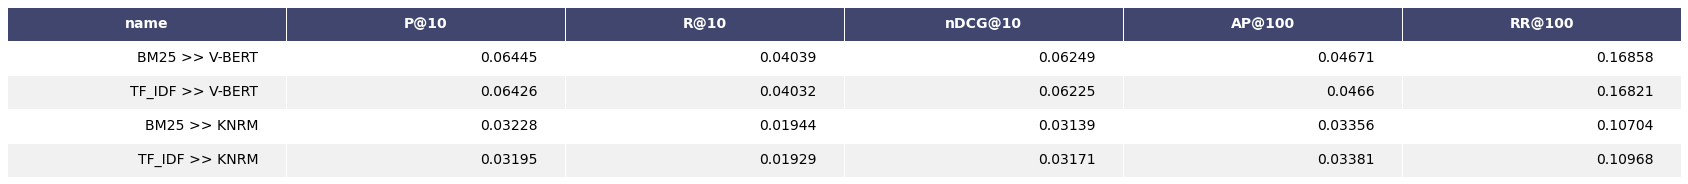

In [ ]:
rerankers_df = compare_results([tfidf_knrm_df, bm25_knrm_df, tfidf_vbert_df, bm25_vbert_df], "rerank_comparison.tex")

Since BM25 gives the best results, we'll try to enhence its results by weighting the pipeline in 2 different ways, first applying a 0.75-0.25 weighting, and then a 0.9-0.1

In [ ]:
df_path = ds_dir+"cache/075bm25_025vbert.csv"

if os.path.exists(df_path):
    print("Loading weighted V-BERT results . . .")
    weighted_bert075_df = pd.read_csv(df_path)

else:
    bm25_weight = .75
    vbert_weight = .25

    vbert = onir_pt.reranker('vanilla_transformer', 'bert', text_field='contents', vocab_config={'train':True})

    bm25_100 = pt.BatchRetrieve(index, wmodel = "BM25") % 100
    bm25_vbert = bm25_100 >> pt.text.get_text(index_ref, "contents") >> vbert

    normalized_bm25 = bm25_100 >> pt.pipelines.PerQueryMaxMinScoreTransformer()
    normalized_bm25_vbert = bm25_vbert >> pt.pipelines.PerQueryMaxMinScoreTransformer()
    sum_bm25_vbert = vbert_weight*normalized_bm25_vbert + bm25_weight*normalized_bm25
    
    weighted_bert075_df = experiment_models([sum_bm25_vbert], [f'BM25 >> {bm25_weight}*BM25 + {vbert_weight}*VBERT'])
    weighted_bert075_df.to_csv(df_path, index=False)

Loading weighted V-BERT results . . .


In [ ]:
df_path = ds_dir+"cache/09bm25_01vbert.csv"

if os.path.exists(df_path):
    print("Loading weighted V-BERT results . . .")
    weighted_bert09_df = pd.read_csv(df_path)

else:
    bm25_weight = .9
    vbert_weight = .1

    vbert = onir_pt.reranker('vanilla_transformer', 'bert', text_field='contents', vocab_config={'train':True})

    bm25_100 = pt.BatchRetrieve(index, wmodel = "BM25") % 100
    bm25_vbert = bm25_100 >> pt.text.get_text(index_ref, "contents") >> vbert

    normalized_bm25 = bm25_100 >> pt.pipelines.PerQueryMaxMinScoreTransformer()
    normalized_bm25_vbert = bm25_vbert >> pt.pipelines.PerQueryMaxMinScoreTransformer()
    sum_bm25_vbert = vbert_weight*normalized_bm25_vbert + bm25_weight*normalized_bm25
    
    weighted_bert09_df = experiment_models([sum_bm25_vbert], [f'BM25 >> {bm25_weight}*BM25 + {vbert_weight}*VBERT'])
    weighted_bert09_df.to_csv(df_path, index=False)

Loading weighted V-BERT results . . .


,name,P@10,R@10,nDCG@10,AP@100,RR@100
0,TF_IDF,0.166384,0.106992,0.190944,0.099761,0.441662
0,BM25 >> 0.9*BM25 + 0.1*VBERT,0.165877,0.106900,0.190214,0.099817,0.438986
2,BM25,0.165584,0.106653,0.189841,0.099566,0.438675
0,BM25 >> 0.75*BM25 + 0.25*VBERT,0.164784,0.106148,0.189365,0.099013,0.440613
0,BM25 >> V-BERT,0.064445,0.040387,0.062490,0.046706,0.168578
0,TF_IDF >> V-BERT,0.064260,0.040323,0.062253,0.046603,0.168213
0,BM25 >> KNRM,0.032276,0.019442,0.031387,0.033564,0.107038
0,TF_IDF >> KNRM,0.031953,0.019286,0.031709,0.033814,0.109683


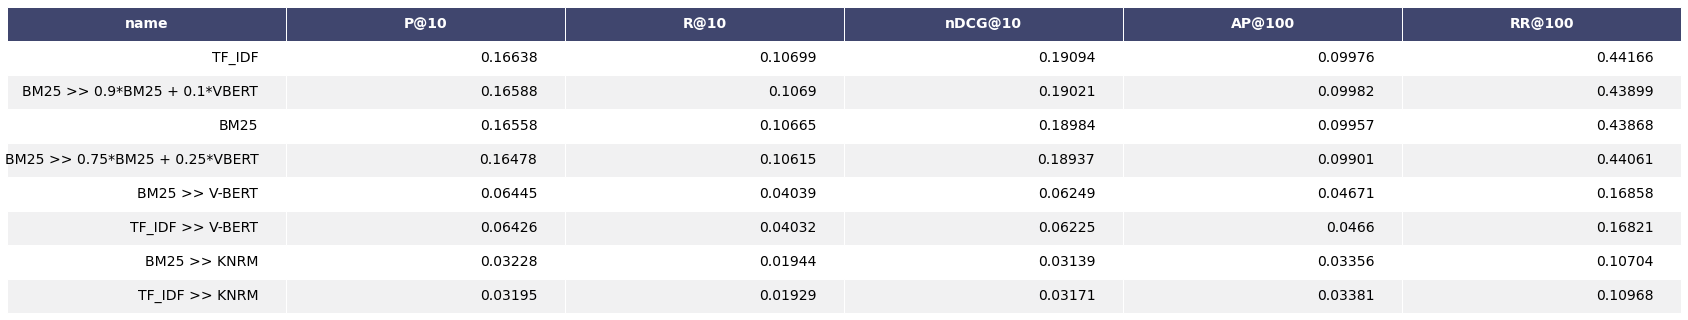

In [ ]:
weighted_rerankers_df = compare_results([top2_df, tfidf_knrm_df, bm25_knrm_df, tfidf_vbert_df,
                                         bm25_vbert_df, weighted_bert075_df, weighted_bert09_df],
                                         "weighted_rerank_comparison.tex")

## Neural Re-Ranker: Tuned BERT

we tried to use a pre-tuned *Bert* model, but since the OpenNir library isn’t that popular, we didn’t manage to find a checkpoint for a dataset related to our problem, and the only other possibility was to perform a fine-tuning from scratch, which wasn’t a viable solution due to the size of the collection and of our train set

In [ ]:
%%script false --no-raise-error

# use a pretrained dataset like MSMarco or EPIC
ds_checkpoint = 'https://to/be/defined'
vbert = onir_pt.reranker.from_checkpoint(ds_checkpoint, text_field='title', expected_md5="854966d0b61543ffffa44cea627ab63b")

## Models Combination: Automatic Ranking Learning

In the following cell we tried to execute an automated ranking learning through a *Random Forest Regressor*, which, based on a train set of queries, learns the best possible pipeline to apply for re-ranking

Even after extracting just a subset of the train queries (50.000 / 550.000) the fit of the model stopped due to RAM limit exceeding after 6 hours of execution

It wasn't possible then to apply such method

In [ ]:
if os.path.exists(ds_dir+"cache/query_subtrain_df.csv") and os.path.exists(ds_dir+"cache/qrels_subtrain_df.csv"):
    print("Loading dataframes from cache . . .")
    
    query_train_df = pd.read_csv(ds_dir+"cache/query_subtrain_df.csv", dtype=str)
    qrels_train_df = pd.read_csv(ds_dir+"cache/qrels_subtrain_df.csv", dtype=str)
    qrels_train_df["label"] = qrels_train_df["label"].astype(int)

else:
    print("Creating dataframes . . .")

    query_train_indexer = Indxr(ds_dir+"train/queries.jsonl")
    print("Train queries: ", len(query_train_indexer))

    query_train_df = pd.DataFrame(columns = ["qid", "query"])
    qrels_train_df = pd.DataFrame(columns = ["qid", "docno", "label"])

    N = 50000 # extract only 50.000 train queries out of total 550.000
    for i in tqdm(range(N)):
        query = query_train_indexer[i]
    
        # append query id and query corpus
        query_train_df.loc[len(query_train_df)] = [str(query["id"]), query["text"]]

        # append all relevant documents
        qrels = query["rel_doc_ids"]
        for id in qrels:
            qrels_train_df.loc[len(qrels_train_df)] = [str(query["id"]), str(id), 1]

    # preprocessing query corpus
    query_train_df["query"] = query_train_df["query"].apply(preprocessing)

    # caching for future executions
    query_train_df.to_csv(ds_dir+"cache/query_subtrain_df.csv", index=False)
    qrels_train_df.to_csv(ds_dir+"cache/qrels_subtrain_df.csv", index=False)
    
display(query_train_df.head())
display(qrels_train_df.head())

Loading dataframes from cache . . .


,qid,query
0,2477357073,survey application layer protocol internet things
1,589973208,interference alignment game theoretical power allocation mimo heterogeneous sensor network communications
2,2150088023,reliable wireless broadcast random network code real time application
3,2161089462,investigate tourist pattern obligation protect environment
4,2157836986,automatic inference structural change matching across program version


,qid,docno,label
0,2477357073,2009221997,1
1,2477357073,2017866470,1
2,2477357073,2120629158,1
3,2477357073,2130630988,1
4,2477357073,2155100177,1


In [ ]:
%%script false --no-raise-error

if os.path.exists(ds_dir+'cache/tfidf_rf.pkl'):
    print("Loading trained pipeline . . .")
    with open(ds_dir+'cache/tfidf_rf.pkl', 'rb') as in_file:
        rf_pipe = pickle.load(in_file)

else:
    from sklearn.ensemble import RandomForestRegressor

    rf = RandomForestRegressor(n_estimators=400)
    rf_pipe = tfidf >> pt.ltr.apply_learned_model(rf)
    rf_pipe.fit(query_train_df, qrels_train_df)

    with open(ds_dir+'cache/tfidf_rf.pkl', 'wb') as out_file:
        pickle.dump(rf_pipe, out_file, pickle.HIGHEST_PROTOCOL)

df_path = ds_dir+"cache/tfidf_rf.csv"

if os.path.exists(df_path):
    print("Loading TF-IDF RandoForest Results . . .")
    tfidf_rf_df = pd.read_csv(df_path)
    
else:   
    tfidf_rf_df = experiment_models([rf_pipe], names=["TFIDF >> RandomForest"])
    tfidf_rf_df.to_csv(df_path, index = False)

display(tfidf_rf_df)

# Final Comparison

The best model is *TF-ID* after applying *KL Divergence*: all the measures are the best ones in relation to the others. Alternatively
using *BM25*, applying *KL Divergence* as well, could be a good choice which slightly deviates
from the previous.

In conclusion, having in disposal a better and more powerful environment can certainly lead to more and better experiments, especially on the neural implementation side

,name,P@10,R@10,nDCG@10,AP@100,RR@100
0,TF-IDF >> KL,0.175050,0.112700,0.197272,0.109632,0.436601
0,BM25 >> KL,0.174065,0.112141,0.196082,0.109301,0.434015
0,TF_IDF,0.166384,0.106992,0.190944,0.099761,0.441662
0,TF-IDF >> TOKENISER,0.166384,0.106992,0.190944,0.099762,0.441666
0,BM25 >> 0.9*BM25 + 0.1*VBERT,0.165877,0.106900,0.190214,0.099817,0.438986
2,BM25,0.165584,0.106653,0.189841,0.099566,0.438675
0,BM25 >> TOKENISER,0.165584,0.106653,0.189841,0.099568,0.438679
0,BM25 >> 0.75*BM25 + 0.25*VBERT,0.164784,0.106148,0.189365,0.099013,0.440613
3,DirichletLM,0.141188,0.090756,0.160028,0.081381,0.377222
0,BM25 >> V-BERT,0.064445,0.040387,0.062490,0.046706,0.168578


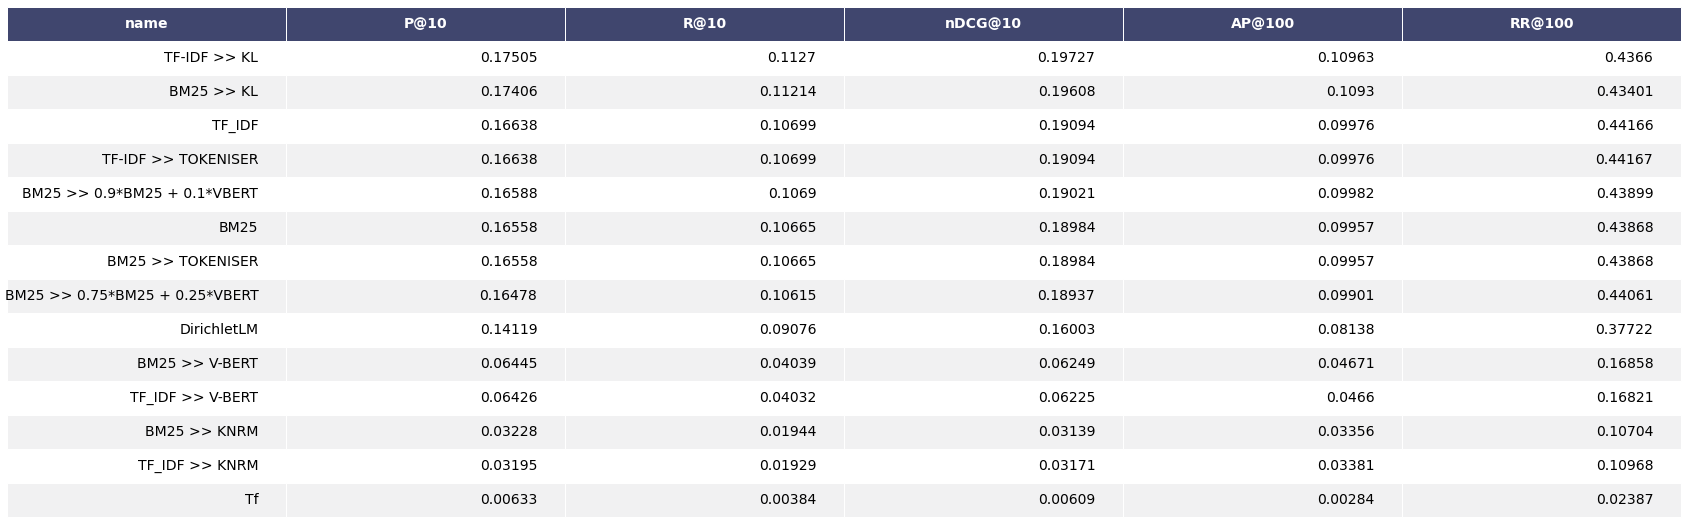

In [ ]:
final_df = compare_results([base_results, tfidf_kl_df, bm25_kl_df, tfidf_tokeniser_df, bm25_tokeniser_df, 
                            tfidf_knrm_df, bm25_knrm_df, tfidf_vbert_df,
                            bm25_vbert_df, weighted_bert075_df, weighted_bert09_df],
                            "final_comparison.tex")